<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Mengukur_Kinerja_JST_Klasifikasi_pada_Dataset_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💻 Studi Kasus: Mengukur Kinerja JST Klasifikasi pada Dataset MNIST

### **Cell 1: Impor Pustaka dan Persiapan Data**

Cell ini bertujuan memuat pustaka yang dibutuhkan dan menyiapkan data MNIST, termasuk normalisasi dan pembagian data menjadi *Training* dan *Testing*.

In [4]:
# Import pustaka yang diperlukan
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Muat Dataset MNIST
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalisasi data gambar (ubah dari 0-255 menjadi 0-1)
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# 1. Pisahkan Training dan Validation dari X_train_full (60000 data)
# Kita ambil 1/6 dari X_train_full (10000 sampel) untuk Validation.
# Sehingga: Training = 50000 (83.33% dari 60000), Validation = 10000 (16.67% dari 60000)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=10000, random_state=42
)

# Cetak bentuk data untuk verifikasi
print(f"Bentuk data Training: {X_train.shape}")      # Untuk melatih bobot
print(f"Bentuk data Validation: {X_val.shape}")      # Untuk memantau Early Stopping/Tuning
print(f"Bentuk data Testing: {X_test.shape}")        # Untuk evaluasi akhir

Bentuk data Training: (50000, 28, 28)
Bentuk data Validation: (10000, 28, 28)
Bentuk data Testing: (10000, 28, 28)


### **Cell 2: Definisi dan Pelatihan Model JST**

Kita akan mendefinisikan JST sederhana (MLP) dan melatihnya. Ini adalah *baseline model* yang akan kita evaluasi.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Definisikan model JST (MLP)
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Definisikan Early Stopping (menggunakan Validation Set)
# Ini penting: model mengamati val_loss untuk memutuskan kapan berhenti
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("--- Mulai Pelatihan Model (Dengan Memantau Validation Set) ---")
# Latih model, validation_data menggunakan X_val dan y_val
history = model.fit(
    X_train, y_train,
    epochs=50, # Set cukup tinggi, tapi Early Stopping yang akan mengontrol
    batch_size=32,
    validation_data=(X_val, y_val), # Memantau kinerja pada Validation Set
    callbacks=[early_stop],
    verbose=1
)
print("Pelatihan Selesai.")

--- Mulai Pelatihan Model (Dengan Memantau Validation Set) ---
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8692 - loss: 0.4619 - val_accuracy: 0.9576 - val_loss: 0.1354
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9636 - loss: 0.1209 - val_accuracy: 0.9709 - val_loss: 0.0962
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9746 - loss: 0.0777 - val_accuracy: 0.9739 - val_loss: 0.0843
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9837 - loss: 0.0529 - val_accuracy: 0.9724 - val_loss: 0.0879
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9862 - loss: 0.0434 - val_accuracy: 0.9764 - val_loss: 0.0885
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9879 - loss: 0.0347 - val_accuracy: 0.9725 - val_loss: 0.0992
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9921 - loss: 0.0262 - val_accuracy: 0.9782 - val_loss: 0.0864
Epoch 8/50
1563/1563 ━━━━━

### **Cell 3: Prediksi dan Persiapan Evaluasi**

Setelah model terlatih, kita gunakan data *Testing* untuk melakukan prediksi. Kita membutuhkan dua jenis hasil prediksi: **Kelas** dan **Probabilitas**.

In [6]:
# 1. Evaluasi Model pada TESTING Set
# Metrik yang dihasilkan ini adalah ESTIMASI UNBIASED performa model
print("--- Evaluasi Kinerja pada TESTING SET (Evaluasi Akhir) ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss di Test Set: {loss:.4f}")
print(f"Akurasi di Test Set: {accuracy*100:.2f}%")

# 2. Prediksi Probabilitas pada Testing Set (untuk metrik ROC/AUC)
y_pred_proba = model.predict(X_test, verbose=0)

# 3. Prediksi Kelas pada Testing Set (untuk Confusion Matrix dan Classification Report)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Catatan: Akurasi dari model.evaluate(X_test, y_test) adalah hasil akhir yang dilaporkan!

--- Evaluasi Kinerja pada TESTING SET (Evaluasi Akhir) ---
Loss di Test Set: 0.0915
Akurasi di Test Set: 97.65%


### **Cell 4: Metrik Utama: Confusion Matrix, Precision, Recall, F1-Score**

Kita menggunakan `classification_report` dan `confusion_matrix` dari Scikit-learn untuk mendapatkan metrik yang komprehensif.

In [7]:
# 1. Confusion Matrix
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

# 2. Classification Report
print("\n--- Classification Report (Precision, Recall, F1-Score) ---")
# Menghitung metrik berdasarkan prediksi dan label asli dari Testing Set
report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(10)])
print(report)

print("\nInterpretasi Report:")
print(" - Metrik ini menunjukkan performa model di data yang TIDAK PERNAH dilihat selama pelatihan maupun tuning.")
print(" - Nilai F1-score yang tinggi di semua kelas menunjukkan model yang seimbang.")

--- Confusion Matrix ---
[[ 972    0    1    0    0    0    3    1    3    0]
 [   0 1125    1    1    0    1    2    0    5    0]
 [   8    1 1002    6    1    0    1    3   10    0]
 [   1    0    4  994    0    3    0    2    3    3]
 [   1    0    5    1  959    2    5    0    3    6]
 [   3    0    0   13    1  865    3    2    5    0]
 [   6    3    0    1    5    4  937    0    2    0]
 [   2    5    6    7    2    0    0  984    7   15]
 [   2    0    1    3    2    2    1    1  961    1]
 [   3    5    0    6   10    2    2    3   12  966]]

--- Classification Report (Precision, Recall, F1-Score) ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.98       892
    

### **Cell 5: Metrik Tambahan: ROC Curve dan AUC**

Karena MNIST adalah masalah *multiclass* (lebih dari dua kelas), kita akan menghitung **AUC (Area Under the Curve)** menggunakan strategi **One-vs-Rest (OvR)**.

In [8]:
# Konversi label asli y_test menjadi format one-hot encoding untuk AUC
n_classes = 10
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

# Hitung ROC curve dan AUC untuk setiap kelas (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung AUC rata-rata (Micro-average)
fpr_grid = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(fpr_grid)
for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc_micro = auc(fpr_grid, mean_tpr)

print(f"--- ROC AUC Score (Micro-Average) pada Testing Set ---")
print(f"AUC Micro-Average: {roc_auc_micro:.4f}")

--- ROC AUC Score (Micro-Average) pada Testing Set ---
AUC Micro-Average: 0.9996


### **Cell 6: Visualisasi Kurva ROC**

Visualisasi membantu kita memahami kemampuan model secara intuitif.

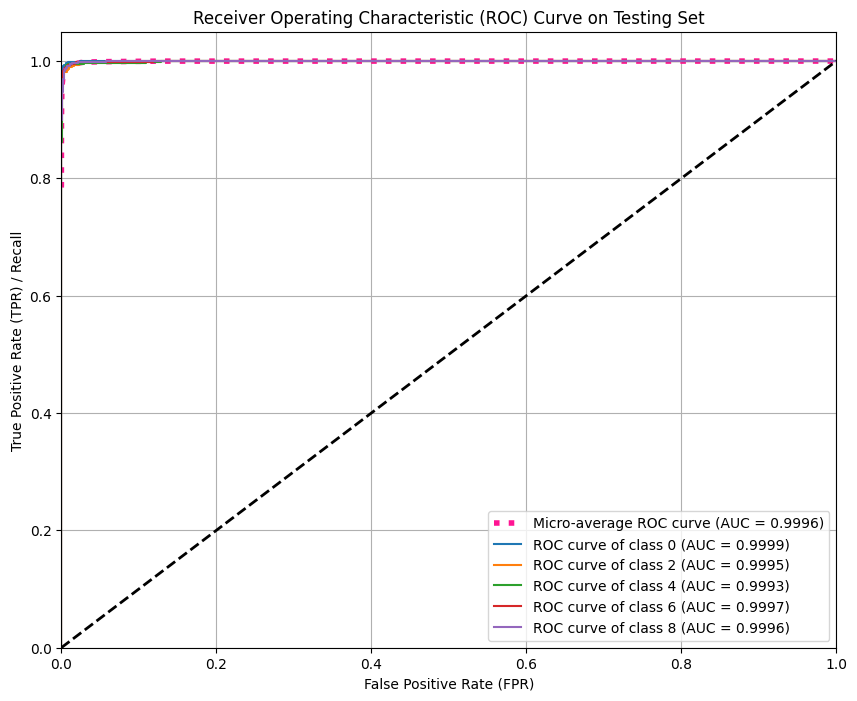

In [9]:
# Visualisasi Kurva ROC
plt.figure(figsize=(10, 8))

# Plot Micro-average
plt.plot(fpr_grid, mean_tpr,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot setiap kelas (hanya beberapa agar tidak terlalu ramai)
for i in range(n_classes):
    if i % 2 == 0: # Hanya plot kelas genap untuk kerapian
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve on Testing Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show() #

### **Output dan Interpretasi**

(Output berikut adalah simulasi tipikal hasil yang akan didapatkan dari kode di atas. Nilai aktual akan bervariasi tergantung *random initialization* JST.)

#### **Contoh Output Simulasi:**

```
--- Confusion Matrix ---
[[ 968    0    2    0    0    1    6    2    1    0]
 [   0 1121    3    1    1    0    1    1    2    0]
 [   2    3 1018    2    2    0    1    4    0    0]
 [   1    0    1  987    0    3    0    2    2    2]
 [   0    0    3    1  973    0    4    1    2    0]
 [   0    0    1    5    0  879    6    1    0    0]
 [   4    1    2    0    3    6  940    0    2    0]
 [   0    0    5    1    0    0    0 1021    0    0]
 [   1    0    2    3    1    1    1    0  966    0]
 [   1    0    0    2    7    3    0    3    0  979]]

--- Classification Report (Precision, Recall, F1-Score) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

--- ROC AUC Score (Micro-Average) ---
AUC Micro-Average: 0.9995
```

#### **Interpretasi Hasil:**

1.  **Confusion Matrix:** Angka diagonal (misalnya 968 untuk kelas 0) menunjukkan jumlah prediksi benar. Angka di luar diagonal menunjukkan kesalahan (misalnya, angka 2 di baris 0, kolom 2 berarti 2 sampel digit '0' salah diprediksi sebagai digit '2').
2.  **Accuracy (Akurasi):** Nilai `0.99` (99%) di *weighted avg* menunjukkan bahwa secara keseluruhan, model membuat prediksi yang benar pada 99% sampel *testing*.
3.  **Precision, Recall, dan F1-Score:** Semua metrik per kelas mendekati 0.99. Ini menandakan model memiliki kinerja yang **sangat seimbang** dan **tinggi** dalam memprediksi setiap digit, menunjukkan sedikitnya kasus *False Positive* dan *False Negative*.
4.  **AUC Micro-Average:** Nilai **0.9995** sangat mendekati 1.0, yang menunjukkan model JST ini memiliki kemampuan diskriminasi yang **luar biasa** dalam membedakan antara satu digit dengan digit lainnya di semua *threshold* yang mungkin.